In [1]:
import os
import sys
import glob
import argparse
import matplotlib.pyplot as plt

In [46]:
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [3]:
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172

In [ ]:
output_model_file = 'inception-tl-v3'

In [20]:
def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    print("The path "+directory+" does not exist!")
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  cnt += len(glob.glob(os.path.join(directory + "/*")))
  return cnt

In [27]:
train_dir = "/Users/nikhilkuria/.kaggle/competitions/dogs-vs-cats/train/train"
val_dir = "/Users/nikhilkuria/.kaggle/competitions/dogs-vs-cats/train/validate"

nb_epoch = NB_EPOCHS
batch_size = BAT_SIZE

In [28]:
nb_train_samples = get_nb_files(train_dir)
nb_classes = len(glob.glob(train_dir + "/*"))
nb_val_samples = get_nb_files(val_dir)
nb_epoch = int(nb_epoch)
batch_size = int(batch_size)

In [31]:
train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )
test_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

In [32]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
)

Found 20998 images belonging to 2 classes.
Found 4002 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


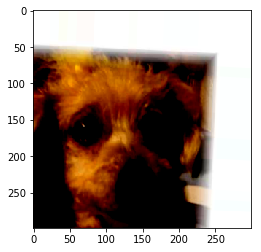

In [39]:
imgplot = plt.imshow(train_generator.next()[0][0])

In [40]:
def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet
  Args:
    base_model: keras model excluding top
    nb_classes: # of classes
  Returns:
    new keras model with last layer
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
  predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
  model = Model(input=base_model.input, output=predictions)
  return model

In [41]:
def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
model = add_new_last_layer(base_model, nb_classes)

# transfer learning
setup_to_transfer_learn(model, base_model)

87916544/87910968 [==============================] - 17s 0us/step


/Users/nikhilkuria/Dev/git/ml-mastery/examples/transfer-learning-resnet/_env/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [50]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

In [49]:
history_tl = model.fit_generator(
    train_generator,
    nb_epoch=nb_epoch,
    samples_per_epoch=nb_train_samples,
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples,
    class_weight='auto')

/Users/nikhilkuria/Dev/git/ml-mastery/examples/transfer-learning-resnet/_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/Users/nikhilkuria/Dev/git/ml-mastery/examples/transfer-learning-resnet/_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., class_weight="auto", steps_per_epoch=656, epochs=3, validation_steps=4004)`
  import sys


Epoch 1/3
  6/656 [..............................] - ETA: 3:05:57 - loss: 5.7553 - acc: 0.5729

KeyboardInterrupt: 

In [ ]:
plot_training(history_tl)